# Monk1 
Grid Search for Monk1 dataset model selection


In [32]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.components.Validation.KFoldCrossValidation import validate
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk1 dataset 

In [33]:
file_path = "MLCup/Data/training_data_split.json"
# Load training and test data from the JSON file
with open(file_path, 'r') as jsonfile:
    data_dict = json.load(jsonfile)

training_data = np.array(data_dict['training_data'])
training_labels = np.array(data_dict['training_labels'])
test_data = np.array(data_dict['test_data'])
test_labels = np.array(data_dict['test_labels'])
train_idx = np.array(data_dict['train_idx'])
test_idx = np.array(data_dict['test_idx'])

In [34]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()][1]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 200
epochs = 1000

final_path = 'MLCup_models_configs8.json'

if not os.path.exists(final_path):
    dir_path = "MLCup/"
    
    all_json_data = read_json_files(dir_path)
    # Get the top 3 most common values
    regularizations = all_json_data['regularization'].unique().tolist()
    regularizations = [1e-7, 1e-8]
    learning_rates = [0.001, 0.005]
    momentums = [0, 0.1, 0.2]
    num_of_layers = [2]
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = all_json_data['initializers'].unique().tolist()
    activations = ['sigmoid']

    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True, outputs=3,
                                     callbacks=["earlystopping"], output_activation='linear', show_line=False,
                                     ).get_configs()
    print(len(myConfigurator))
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
                              batch_size=batch_size, num_models=100, number_of_initializations=2, regression=True,
                              ))

        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_path)
else: 
    with open(final_path, 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [35]:
my_configs = []
for config in configs[1]:
    config['callbacks'] = ['earlystopping_1e-2_50_False_True']
# ea = EarlyStoppingCallback(restore_weights=True)
if __name__ == '__main__':
    # for config in configs[1]:
    #     config['callbacks'] = [ea]
    my_configs.append(
        # hold_out(configs[1], training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
        #                   batch_size=250, num_models=100, number_of_initializations=2, regression=True,
        #                   ))
    
        validate(configs[1], x=training_data, y_true=training_labels, epochs=epochs, return_models_history=True,
                          batch_size=batch_size, max_configs=100, number_of_initializations=2, n_splits=4
                          ))

configs=my_configs[0]

Models: 100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


In [36]:
models = []
old_histories = configs[0]
my_configs=configs[1]
with tqdm(total=len(my_configs)) as pbar:
    for old_hist, config in zip(old_histories, my_configs):
        model = Composer(config=config).compose(regression=True)
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels, metrics=['mse', 'mee'])
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mee'])), model.get_last()['mee'], test_val[0], test_val[1], model.curr_epoch, model.best_epoch, np.min(old_hist['mee']),  np.min(old_hist['val_mee']), old_hist['mee'],  old_hist['val_mee'], model.history['mee'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Mee', 'Test_Score', 'Test_Mee', 'Trained_Epochs', 'Old_Best_Epochs', 'Old_History_Last', 'Old_History_val_Last', 'Old_History', 'Old_History_val', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


In [50]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
df_sorted = df_sorted[df_sorted['Test_Mee'] <= 1.5]
# df_sorted = df_sorted[df_sorted['Old_History_val_Last'] <= 1.6]
# df_sorted = df_sorted[df_sorted['Test_Mee'] >= 1.3]
# df_sorted = df_sorted[df_sorted['Old_History_val_Last'] <= 1.4]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 5]
df_sorted['Old_diff'] = np.abs(df_sorted['Old_History_Last'] - df_sorted['Old_History_val_Last'])
# df_sorted = df_sorted[df_sorted['Old_diff'] <= 0.35]
# df_sorted = df_sorted[df_sorted['Old_diff'] <= 0.1]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
df_sorted

,Score,History_Std,Mee,Test_Score,Test_Mee,Trained_Epochs,Old_Best_Epochs,Old_History_Last,Old_History_val_Last,Old_History,Old_History_val,History,Model,Config,Num_Layers,Num_of_Units,Name,Old_diff
29,2.441006,5.247406,1.308453,3.420375,1.486366,1000,995,1.599793,1.793149,"[42.63205, 40.35945, 37.752094, 36.446907, 35....","[43.65641, 40.954056, 38.464634, 37.09718, 35....","[43.139828, 39.851757, 38.090096, 37.098415, 3...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-08, 'learning_rate': 0.0...",2,"[20, 20]",Model391,0.193356
3,2.475111,5.047002,1.319543,3.416319,1.496479,1000,995,1.502582,1.562069,"[42.93092, 42.19135, 38.661358, 37.552208, 36....","[42.681168, 42.313408, 38.706947, 37.57797, 36...","[42.750225, 38.57251, 36.42138, 34.67829, 33.3...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.0...",2,"[20, 20]",Model175,0.059486


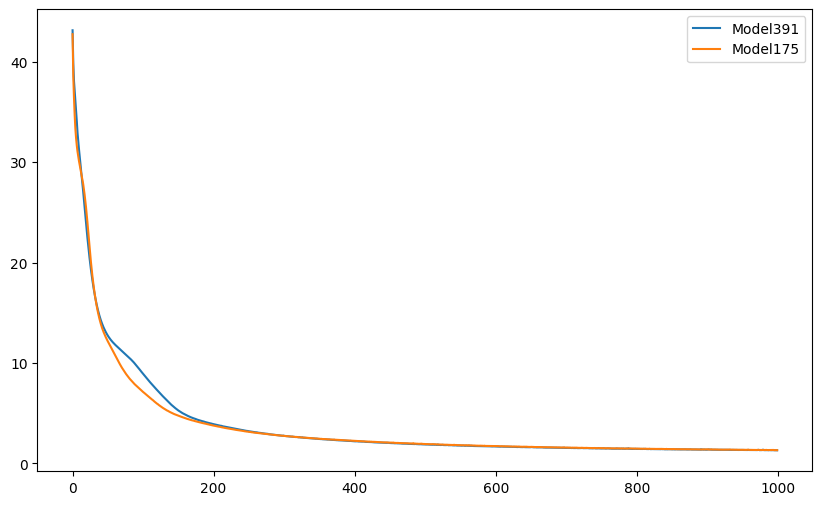

In [51]:
plot_history(histories)
# plot_history({list(histories)[1]: -np.sort(-np.array(list(histories.values())[1]))})

Selected row:
Score                                                            2.475111
History_Std                                                      5.047002
Mee                                                              1.319543
Test_Score                                                       3.416319
Test_Mee                                                         1.496479
Trained_Epochs                                                       1000
Old_Best_Epochs                                                       995
Old_History_Last                                                 1.502582
Old_History_val_Last                                             1.562069
Old_History             [42.93092, 42.19135, 38.661358, 37.552208, 36....
Old_History_val         [42.681168, 42.313408, 38.706947, 37.57797, 36...
History                 [42.750225, 38.57251, 36.42138, 34.67829, 33.3...
Model                   <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config                  

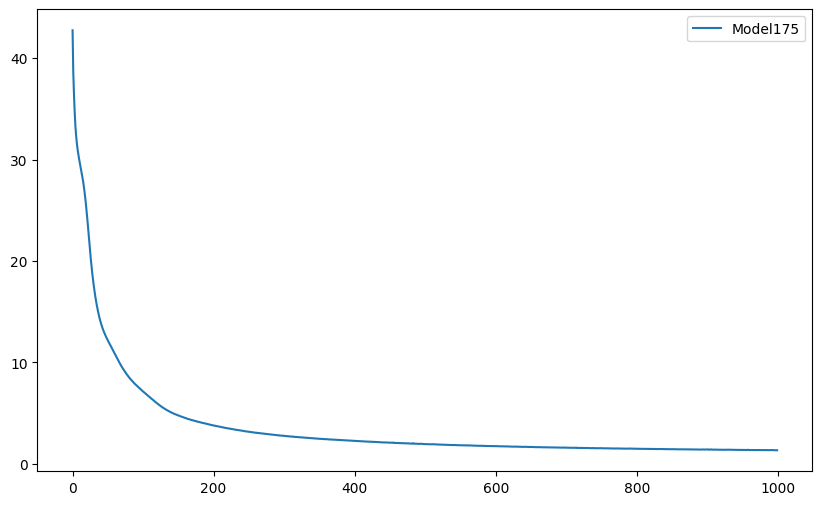

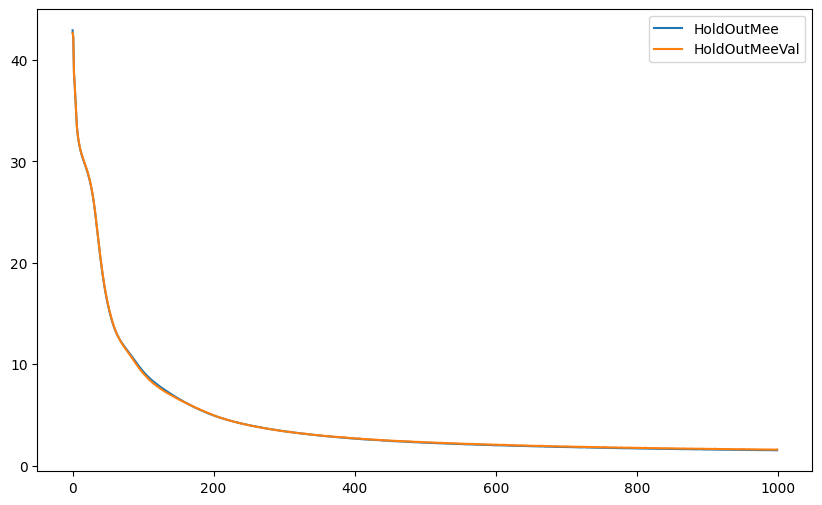

In [53]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array = np.array(row['History'])
        differences =  (np.diff(array) - np.mean(array)) /np.mean(array) 
        # differences =  (np.diff(array) / np.mean(array)) 
        min_consecutive_difference = np.min(differences)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
print(result_row['Config'])
plot_history({result_row["Name"]: result_row['History']})
plot_history({'HoldOutMee': result_row['Old_History'], 'HoldOutMeeVal': result_row['Old_History_val']})
result_row.to_csv('MLCup_FirstTry.csv')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


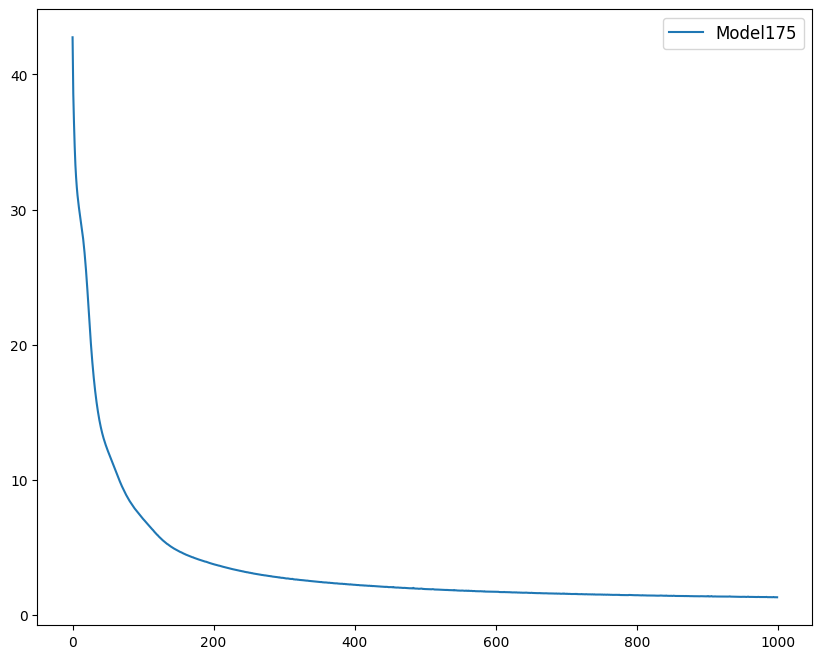

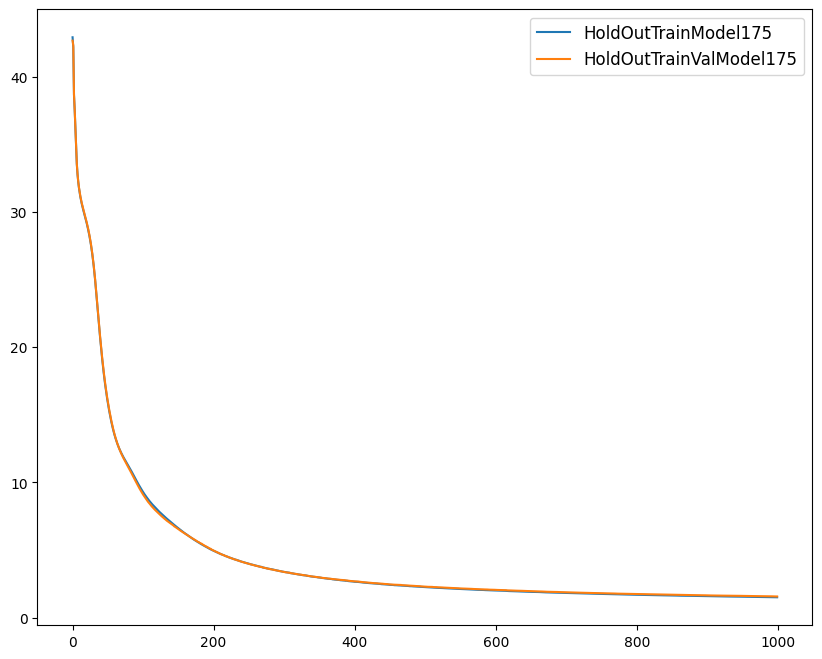

In [54]:
import matplotlib.pyplot as plt
def plot_history2(name, lines: dict, fig_size=(10, 6)):
    plt.figure(figsize=fig_size)
    for elem in lines:
        plt.plot(lines[elem], label=elem)
    plt.legend(fontsize=12)
    plt.savefig(name+'.eps', format='eps')
    plt.savefig(name+'.png', format='png')

plot_history2(name='MLCup_train', lines={result_row["Name"]: result_row['History']}, fig_size=(10,8))
plot_history2(name='MLCup_HoldOut', lines={'HoldOutTrain'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History'])), 'HoldOutTrainVal'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History_val']))}, fig_size=(10,8))
